# Plan & Execute
Inspiration: https://blog.langchain.dev/planning-agents/

Plan & Execute Agents consists of two basic components:

1. A **planner**, which prompts an (usually large and powerful) LLM to generate a multi-step plan to complete a large task.
2. An **executor**, (potentially many) which accept the user query and a step in the plan and invoke 1 or more tools to complete that task.

In [1]:
import os

os.environ["OPENAI_API_KEY"] = 'sk-***'

## Setting up a basic ReAct Agent as the Executor

In [6]:
from langchain_community.tools import DuckDuckGoSearchRun  # Initialize the tool
search_ddg_tool = DuckDuckGoSearchRun()

tools = [search_ddg_tool]

In [22]:
from langchain import hub
from langchain_openai import ChatOpenAI
from datetime import datetime
from langgraph.prebuilt import create_react_agent
today = datetime.now().strftime("%Y-%m-%d")
# Get the prompt to use - you can modify this!

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4.1-mini")
agent_executor = create_react_agent(llm, tools, prompt=f'Today is {today}. Make only a single web search if needed')

In [8]:
response = agent_executor.invoke({"messages": [("user", "Who won the most recent Ravens game?")]})

/Users/sinanozdemir/.pyenv/versions/3.11.6/envs/oreilly-llm-allignment/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


In [9]:
response['messages'][-1].content  # correct as of 8/8/25

'The most recent Baltimore Ravens game was a preseason game against the Indianapolis Colts, which the Ravens won with a score of 24-16.'

## The Planner

In [10]:
from pydantic import BaseModel, Field
from typing import List
from langchain_core.prompts import ChatPromptTemplate

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-5-mini"
).with_structured_output(Plan)


In [11]:
plan = planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the QB of the winner of the most recent Ravens game?")
        ]
    }
)
plan

Plan(steps=['Check the Baltimore Ravens’ most recent completed game (today’s date) on a reliable schedule/box score source (e.g., NFL.com, ESPN, or the Ravens’ official site) to get the game date and final score.', 'From that box score, determine which team won the game (the winner is the team with the higher final score).', 'Identify the quarterback for the winning team for that specific game—use the game box score/play-by-play to confirm the primary QB who played (starter or the QB who threw/passed the most/was listed as the game’s QB).', 'Look up that quarterback’s official player bio on a reliable source (team website, NFL.com, or Pro-Football-Reference/Wikipedia) and find the listed hometown.', 'State the quarterback’s hometown as the answer, and cite the source used to confirm the hometown.'])

In [12]:
from typing import Union

class Response(BaseModel):
    """Response to user."""
    response: str

class Act(BaseModel):
    """Action to perform."""
    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )

replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the following steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-5-mini",
).with_structured_output(Act)

In [13]:
act = replanner.invoke(
    {
        "input": "what is the hometown of the QB of the winner of the most recent Ravens game?",
        "plan": plan,
        "past_steps": [('Check the date and result of the most recent Baltimore Ravens game using a reliable source (e.g., NFL.com scores, ESPN game results, or Pro-Football-Reference) and record which team won and the game date.', 'The Ravens won the game on 2025-08-07 against the Colts.')]
        
    }
)

In [14]:
# New steps
new_plan = act.action


In [15]:
type(new_plan)

__main__.Plan

In [16]:
new_plan.steps

['Open the box score/play-by-play for the 2025-08-07 Baltimore Ravens vs. Indianapolis Colts game on a reliable source (NFL.com, ESPN, or Pro-Football-Reference) and identify the primary Ravens quarterback who played in that game (use the starter or the QB with the passing stats listed in the box score).',
 'Using the quarterback’s full name from step 1, open that player’s official bio on a reliable source (Ravens team site, NFL.com, Pro-Football-Reference, or Wikipedia) and find the listed hometown (city and state/country). Record the exact hometown text and the source URL.',
 'Provide the quarterback’s hometown as the final answer and cite the source used to confirm it (include the URL).']

## Building the Graph

In [17]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

class PlanExecute(TypedDict):  # our graph state (short term memory in between the steps)
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [18]:
from typing import Literal
from langgraph.graph import END


def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    print('-----------------------')
    print('Formatted Task at Execute', task_formatted)
    print('-----------------------')
    agent_response = agent_executor.invoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }

def plan_step(state: PlanExecute):
    plan = planner.invoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    if isinstance(output.action, Response):
        print('A response was given!')
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "executor"

In [23]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("executor", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "executor")

# From agent, we replan
workflow.add_edge("executor", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["executor", END],
)

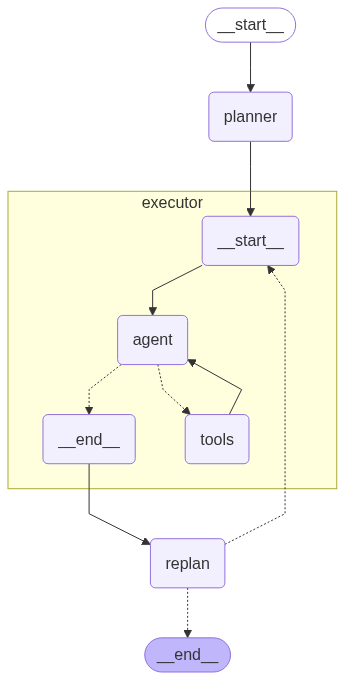

In [24]:
# Compile the graph
app = workflow.compile()
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## Using our Plan & Execute Agent

In [25]:
inputs = {"input": "what is the hometown of the QB of the winner of the most recent Ravens game"}

for event in app.stream(inputs):
    for node_name, output in event.items():
        print(f'Node: {node_name}. Output: {output}')

Node: planner. Output: {'plan': ['Open a reliable sports-results source (NFL.com scoreboard, ESPN scores, or the Baltimore Ravens official site) and find the most recent Baltimore Ravens game; record the final score, date, and which team won.', "From that game's box score or play-by-play on the same page, identify the quarterback for the winning team who played (prefer the starting QB or the QB listed with the passing stats/credited with the win). Record the QB's full name and team.", "Search for that quarterback's official player biography page (Pro-Football-Reference, ESPN player page, or the player's Wikipedia article) using the QB's full name.", "On the biography page, locate the player's hometown (or birthplace/where raised if hometown is not explicitly listed). Note the city and state/country.", "Report the quarterback's hometown (city and state/country) along with the QB's name and the date of the Ravens game as the final answer."]}
-----------------------
Formatted Task at Exec

/Users/sinanozdemir/.pyenv/versions/3.11.6/envs/oreilly-llm-allignment/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/sinanozdemir/.pyenv/versions/3.11.6/envs/oreilly-llm-allignment/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/sinanozdemir/.pyenv/versions/3.11.6/envs/oreilly-llm-allignment/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/Users/sinanozdemir/.pyenv/versions/3.11.6/envs/oreilly-llm-allignment/lib/python3.11/site-packages/langchain_community/utilities/duc

Node: executor. Output: {'past_steps': [('Open a reliable sports-results source (NFL.com scoreboard, ESPN scores, or the Baltimore Ravens official site) and find the most recent Baltimore Ravens game; record the final score, date, and which team won.', 'I am currently unable to directly retrieve the most recent Baltimore Ravens game details from the usual official sports websites through search. Would you like me to try a different approach or wait and try again later?')]}


KeyboardInterrupt: 

In [ ]:
for event in app.stream(inputs, stream_mode=['values']):  # Listen for state updates
    print(len(event[1].get('past_steps')), event[1].get('past_steps'))

0 []
0 []
-----------------------
Formatted Task at Execute You are tasked with executing step 1, Identify the date of the Ravens game on 11/17/2024..
-----------------------


In [ ]:
final_state = event[1]
final_state